## Chapter 2 Tokenization & Word Embedding

### Large Language Model Data Preprocessing
1. raw text data --> word embeddings:
    - input text --> tokenized text
    - tokenized text --> token ids
    - token ids --> token embeddings
    - token embeddings --> token embeddings + pos embeddings
2. 纯文本转化为数字ID，数字ID转化为词向量，词向量+位置信息成为大模型的输入。
3. 可以使用特殊符号<|endoftext|>，<|unk|>来表示字典中结束生成字符和缺少的字符。或是使用BytePair encoding，将单词进行拆解后编码（预防遇到unknown词汇）。

In [2]:
# 1. raw text --> tokenized text
# TODO how does tiktoken work? how will chinese words work?
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
text = "Hello, do you like tea? <|endoftext|> In the sunlit terraces of someunknownPlace."
text_ids = tokenizer.encode(text,allowed_special={"<|endoftext|>"})
print(text_ids)
ids_decoded = tokenizer.decode(text_ids)
print(ids_decoded)

[15496, 11, 466, 345, 588, 8887, 30, 220, 50256, 554, 262, 4252, 18250, 8812, 2114, 286, 617, 34680, 27271, 13]
Hello, do you like tea? <|endoftext|> In the sunlit terraces of someunknownPlace.


### Training Data of Large Language Models
1. The training data of large language models is using previous seen sequence to predict the next token.
    - ex: LLMs learn (to) (predict) ... (<|endoftext|), the model takes "LLMs learn" as input and generate one output token "to", and then concate them as input "LLMs learn to" to generate the next token till the "<|endoftext|>". (autoregressive)
2. Use a slicing window to create model inputs.

In [4]:
# Use a slicing window to create model inputs
example_data_path = r"D:\xtLLM\AI playground\LLMsFromScratch\ch02\01_main-chapter-code\the-verdict.txt"
with open(example_data_path,"r",encoding = "utf-8" ) as f:
    raw_text = f.read()
encoded_text = tokenizer.encode(raw_text)
context_size = 10
stride = 2
first_slicing = encoded_text[:context_size]
second_slicing = encoded_text[stride:context_size+stride]
print(f"first_slicing: {first_slicing}")
print(f"second_slicing:      {second_slicing}")

first_slicing: [40, 367, 2885, 1464, 1807, 3619, 402, 271, 10899, 2138]
second_slicing:      [2885, 1464, 1807, 3619, 402, 271, 10899, 2138, 257, 7026]


In [9]:
print("llm inputs: ----> llm target")
for i in range(1,context_size+1):
    input_ids = encoded_text[:i]
    target_ids = encoded_text[i]
    print(input_ids,"---->",target_ids)

llm inputs: ----> llm target
[40] ----> 367
[40, 367] ----> 2885
[40, 367, 2885] ----> 1464
[40, 367, 2885, 1464] ----> 1807
[40, 367, 2885, 1464, 1807] ----> 3619
[40, 367, 2885, 1464, 1807, 3619] ----> 402
[40, 367, 2885, 1464, 1807, 3619, 402] ----> 271
[40, 367, 2885, 1464, 1807, 3619, 402, 271] ----> 10899
[40, 367, 2885, 1464, 1807, 3619, 402, 271, 10899] ----> 2138
[40, 367, 2885, 1464, 1807, 3619, 402, 271, 10899, 2138] ----> 257


In [7]:
for i in range(1,context_size+1):
    input_ids = encoded_text[:i]
    target_ids = encoded_text[i]
    print(tokenizer.decode(input_ids),"---->",tokenizer.decode([target_ids]))

I ---->  H
I H ----> AD
I HAD ---->  always
I HAD always ---->  thought
I HAD always thought ---->  Jack
I HAD always thought Jack ---->  G
I HAD always thought Jack G ----> is
I HAD always thought Jack Gis ----> burn
I HAD always thought Jack Gisburn ---->  rather
I HAD always thought Jack Gisburn rather ---->  a


In [13]:
import torch 
from torch.utils.data import Dataset,DataLoader

class MyDataset(Dataset):
    def __init__(self,txt,tokenizer,max_length,stride):
        # txt: raw text input
        # tokenizer: tiktoken tokenizer
        # max_length: maximum length of text in one window
        # stride: stride of shifting
        self.input_ids = []
        self.target_ids = []
        token_ids = tokenizer.encode(txt,allowed_special={"<|endoftext>"})
        for i in range(0,len(token_ids)-max_length,stride):
            input_chunk = token_ids[i:i+max_length]
            target_chunk = token_ids[i+1:i+max_length+1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))
            
    def __len__(self):
        return len(self.input_ids)
    
    def __getitem__(self,idx):
        return self.input_ids[idx],self.target_ids[idx]

my_data = MyDataset(raw_text,tokenizer,max_length=4,stride=4)
my_dataloader = DataLoader(my_data,batch_size = 8)
data_iter = iter(my_dataloader)
inputs,targets = next(data_iter)
print(inputs)
print(targets)

tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])
tensor([[  367,  2885,  1464,  1807],
        [ 3619,   402,   271, 10899],
        [ 2138,   257,  7026, 15632],
        [  438,  2016,   257,   922],
        [ 5891,  1576,   438,   568],
        [  340,   373,   645,  1049],
        [ 5975,   284,   502,   284],
        [ 3285,   326,    11,   287]])


In [18]:
# word embedding
# 将input ids转化成高纬向量形式，每个token都将转化为维度相同的向量。
# torch.nn.Embedding is a lookup table that store {id:vector} pairs
# this embedding layer is trainable during the training process(similar to w2v)
vocab_size = 6
output_dim = 3
embedding_layer = torch.nn.Embedding(vocab_size,output_dim)
print(embedding_layer.weight)

Parameter containing:
tensor([[ 0.1474, -2.1902, -2.2966],
        [ 1.0853, -1.9754, -1.3972],
        [-1.2581, -1.0070,  1.0953],
        [ 0.8421,  1.3301,  1.1487],
        [-0.0118,  1.4984, -0.7885],
        [-1.4082, -1.5428,  0.6157]], requires_grad=True)


In [19]:
print(embedding_layer(torch.tensor([3]))) # one token id is represented by a 3-dim vector

tensor([[0.8421, 1.3301, 1.1487]], grad_fn=<EmbeddingBackward0>)


In [22]:

vocab_size = 50257
output_dim = 256

token_embedding_layer = torch.nn.Embedding(vocab_size, output_dim)
my_data = MyDataset(raw_text,tokenizer,max_length=4,stride=4)
my_dataloader = DataLoader(my_data,batch_size = 8)
data_iter = iter(my_dataloader)
inputs,targets = next(data_iter)
print("Token IDs:\n", inputs)
print("\nInputs shape:\n", inputs.shape)
print("targets IDs:\n", targets)
print("\targets shape:\n", targets.shape)

Token IDs:
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])

Inputs shape:
 torch.Size([8, 4])
targets IDs:
 tensor([[  367,  2885,  1464,  1807],
        [ 3619,   402,   271, 10899],
        [ 2138,   257,  7026, 15632],
        [  438,  2016,   257,   922],
        [ 5891,  1576,   438,   568],
        [  340,   373,   645,  1049],
        [ 5975,   284,   502,   284],
        [ 3285,   326,    11,   287]])
	argets shape:
 torch.Size([8, 4])


In [21]:
token_embeddings = token_embedding_layer(inputs)
print(token_embeddings.shape)
token_embeddings

torch.Size([8, 4, 256])


tensor([[[ 0.3510, -0.5757, -1.5736,  ..., -1.6253, -0.3289, -0.9933],
         [-1.1081,  0.2274,  0.6203,  ...,  1.5479, -1.8518,  1.1442],
         [-0.9267,  0.8849, -0.5649,  ..., -0.4379, -0.1542,  0.8026],
         [-0.5939,  0.0826, -1.7491,  ..., -0.9792,  0.4369, -0.1986]],

        [[ 2.0469, -0.2555,  1.6866,  ..., -0.2410, -0.8813, -1.0781],
         [ 0.9166, -0.1945, -1.0540,  ...,  0.5471, -1.8863,  0.0295],
         [ 0.3098,  0.4088,  0.1337,  ..., -0.4947, -0.2524, -2.6513],
         [ 1.2139,  0.2736,  2.2948,  ..., -0.5649, -0.9337, -0.0517]],

        [[ 1.2241, -0.2724, -0.2569,  ...,  1.4578,  1.4006,  2.2211],
         [-0.5525, -0.1110, -0.2867,  ..., -2.5327, -0.3971,  0.5921],
         [ 1.4675,  0.5508,  0.1313,  ...,  0.2010,  0.2372, -0.0966],
         [-0.6726, -0.7986, -0.1320,  ..., -0.5562,  1.8020, -0.6285]],

        ...,

        [[ 0.6011, -0.4326,  1.0781,  ..., -1.4406, -1.3300, -0.5436],
         [-0.5380, -1.1697,  0.7563,  ...,  0.4654,  2.77

In [26]:
# this is a trainable positional embedding
# the positional embedding is able to learn the positional information of input sequence
# mainly the positional embedding layer is a trainable lookup table with input of [0,context_length]
context_length = 4
pos_embedding_layer = torch.nn.Embedding(context_length, output_dim)
pos_embeddings = pos_embedding_layer(torch.arange(context_length))
print(pos_embeddings)


tensor([[-0.5952,  1.1378,  0.8064,  ...,  0.1229,  0.4559, -1.6080],
        [-1.0853,  2.2335,  0.6375,  ..., -0.6232, -2.5646, -1.1339],
        [ 1.0444, -3.0779, -0.3743,  ...,  1.9803,  0.1562,  0.1169],
        [ 1.2798, -0.1913,  0.8160,  ...,  0.6105, -0.7060, -0.1789]],
       grad_fn=<EmbeddingBackward0>)


In [27]:
input_embeddings = token_embeddings + pos_embeddings
print(input_embeddings)

tensor([[[-2.4423e-01,  5.6213e-01, -7.6724e-01,  ..., -1.5024e+00,
           1.2700e-01, -2.6013e+00],
         [-2.1934e+00,  2.4609e+00,  1.2578e+00,  ...,  9.2471e-01,
          -4.4164e+00,  1.0336e-02],
         [ 1.1773e-01, -2.1930e+00, -9.3927e-01,  ...,  1.5424e+00,
           2.0327e-03,  9.1954e-01],
         [ 6.8598e-01, -1.0875e-01, -9.3317e-01,  ..., -3.6874e-01,
          -2.6917e-01, -3.7754e-01]],

        [[ 1.4517e+00,  8.8231e-01,  2.4930e+00,  ..., -1.1809e-01,
          -4.2541e-01, -2.6860e+00],
         [-1.6873e-01,  2.0390e+00, -4.1655e-01,  ..., -7.6058e-02,
          -4.4509e+00, -1.1043e+00],
         [ 1.3542e+00, -2.6691e+00, -2.4060e-01,  ...,  1.4856e+00,
          -9.6197e-02, -2.5343e+00],
         [ 2.4938e+00,  8.2252e-02,  3.1107e+00,  ...,  4.5553e-02,
          -1.6397e+00, -2.3061e-01]],

        [[ 6.2891e-01,  8.6536e-01,  5.4950e-01,  ...,  1.5807e+00,
           1.8565e+00,  6.1314e-01],
         [-1.6378e+00,  2.1226e+00,  3.5076e-01,  .

## Chapter 3 Attention Mechanism

In [124]:
import torch
# create a input tensor as tensor flowing in decoder
inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)
)
# the query is the value of current focusing token
# the key is the value of all the tokens in the sequence
# the attn score is computed by q & k
# get the weighted attn score --> attn weights
# put attn weights and value of each token together and summation (weighted sum)
query = inputs[1]  # 2nd input token is the query
attn_scores_2 = torch.empty(inputs.shape[0])
for i, x_i in enumerate(inputs):
    attn_scores_2[i] = torch.dot(x_i, query) # dot product (transpose not necessary here since they are 1-dim vectors)

print(attn_scores_2)

tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])


In [125]:
attn_weights_2_tmp = attn_scores_2 / attn_scores_2.sum()

print("Attention weights:", attn_weights_2_tmp)
print("Sum:", attn_weights_2_tmp.sum())

Attention weights: tensor([0.1455, 0.2278, 0.2249, 0.1285, 0.1077, 0.1656])
Sum: tensor(1.0000)


In [126]:
def softmax_naive(x):
    return torch.exp(x) / torch.exp(x).sum(dim=0)

attn_weights_2_naive = softmax_naive(attn_scores_2)

print("Attention weights:", attn_weights_2_naive)
print("Sum:", attn_weights_2_naive.sum())

Attention weights: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum: tensor(1.)


### scaled dot-product attention
- introducing Wq, Wk, Wv trainable matrices for each attention head.
- one attention head has one set of Wq, Wk, Wv
- Wq is used when the token is computing its own attn weights
- Wk is used with Wq that represents how much attention is needed for others to pay attention to it with Wq
- attention weights are get by Wq and Wk
- using attention weights and Wv to get the current value of input token with respect to other tokens in the sequence

In [127]:
inputs # assuming the input sequence has 6 tokens with dim 3

tensor([[0.4300, 0.1500, 0.8900],
        [0.5500, 0.8700, 0.6600],
        [0.5700, 0.8500, 0.6400],
        [0.2200, 0.5800, 0.3300],
        [0.7700, 0.2500, 0.1000],
        [0.0500, 0.8000, 0.5500]])

In [128]:
torch.manual_seed(123)
d_in = 3 # input dimension is 3
d_out = 2 # output dimension is 2
W_query = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False) # define a Wq
W_key   = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False) # define a Wk
W_value = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False) # define a Wv

In [129]:
x_2 = inputs[1]
#see the q,k,v values of a input
query_2 = x_2 @ W_query 
key_2 = x_2 @ W_key 
value_2 = x_2 @ W_value

print('query:',query_2)
print('key:',key_2)
print('value:',value_2)

query: tensor([0.4306, 1.4551])
key: tensor([0.4433, 1.1419])
value: tensor([0.3951, 1.0037])


In [130]:
keys = inputs @ W_key 
values = inputs @ W_value

print("keys.shape:", keys.shape)
print("values.shape:", values.shape)

keys.shape: torch.Size([6, 2])
values.shape: torch.Size([6, 2])


In [131]:
# calculate attn score,attn weights of x_2 wrt. all other tokens
attn_score_2 = query_2 @ keys.T
d_k= keys.shape[1] # divide attn score by square root of embedding dimension
print('attn score:',attn_scores_2)
attn_weights_2 = torch.softmax(attn_score_2 / d_k**0.5,dim=-1)
print('attn weights: ',attn_weights_2)

attn score: tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])
attn weights:  tensor([0.1500, 0.2264, 0.2199, 0.1311, 0.0906, 0.1820])


In [132]:
# get the final value 
context_vec_2 = attn_weights_2 @ values
print(context_vec_2)

tensor([0.3061, 0.8210])


### CausalAttention head

In [18]:
import torch.nn as nn
class CausalAttention(nn.Module):
    def __init__(self,d_in,d_out,context_length,dropout,qkv_bias=False):
        super().__init__()
        self.d_in = d_in # input word embedding vector dimension
        self.d_out = d_out # output dimension of this attention head
        self.W_query = nn.Linear(d_in,d_out,bias=qkv_bias) # remove bias, treat it as simple matrix ope
        self.W_key = nn.Linear(d_in,d_out,bias=qkv_bias) # remove bias, treat it as simple matrix ope
        self.W_value = nn.Linear(d_in,d_out,bias=qkv_bias) # remove bias, treat it as simple matrix ope
        self.dropout = nn.Dropout(dropout)
        #self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1)) # New
        self.mask = torch.triu(torch.ones(context_length,context_length) * (-torch.inf),diagonal=1)
        
    def forward(self,x): # x: a batch of input
        b,num_tokens,d_in = x.shape
        queries = self.W_query(x)
        keys = self.W_query(x)
        values = self.W_value(x)
        attn_scores = torch.matmul(queries,keys.mT)
        attn_scores.masked_fill_(self.mask.bool()[:num_tokens,:num_tokens],-torch.inf)
        attn_weights = torch.softmax(attn_scores/keys.shape[-1]**0.5,dim=-1)
        attn_weights = self.dropout(attn_weights)
        context_vec = torch.matmul(attn_weights,values)
        return context_vec 
    
class MultiHeadAttention(nn.Module):
    def __init__(self,d_in,d_out,context_length,dropout,num_heads,qkv_bias=False):
        super().__init__()
        self.heads = nn.ModuleList(
            [CausalAttention(d_in,d_out,context_length,dropout,qkv_bias) for _ in range(num_heads)]
        )
    def forward(self,x):
        return torch.cat([head(x) for head in self.heads],dim=-1)
        
torch.manual_seed(123)
batch = torch.stack((inputs,inputs),dim=0)
context_length = batch.shape[1] # This is the number of tokens
d_in, d_out = 3, 2
mha = MultiHeadAttention(
    d_in, d_out, context_length, 0.0, num_heads=2
)

context_vecs = mha(batch)

print(context_vecs)
print("context_vecs.shape:", context_vecs.shape) 

NameError: name 'inputs' is not defined

**X** inputs: (6 x 3) [(batch = 1) x (seq_len = 6) x (embed_dim = 3)]
        [
            [0.4300, 0.1500, 0.8900],   x_1
            [0.5500, 0.8700, 0.6600],   x_2
            [0.5700, 0.8500, 0.6400],   x_3
            [0.2200, 0.5800, 0.3300],   x_4
            [0.7700, 0.2500, 0.1000],   x_5
            [0.0500, 0.8000, 0.5500]    x_6
        ]
**Wq** query matrix: (2 x 3)
        [   
            [-0.2354,  0.0191, -0.2867],
            [0.2177, -0.4919,  0.4232]
        ]

**Wk** key matrix: (2 x 3)
        [
            [-0.4196, -0.4590, -0.3648],
            [0.2615, -0.2133,  0.2161]
        ]

**Wv** value matrix: (2 x 3)
        [
            [-0.4900, -0.3503, -0.2120],
            [-0.1135, -0.4404,  0.3780]
        ]


calculate queries of each input word:
        queries = inputs (6 x 3) @ query matrix^T (3 x 2)
            queries: (6 x 2)
                [       
                        [-0.3536,  0.3965], x_1 query
                        [-0.3021, -0.0289], x_2 query
                        [-0.3015, -0.0232], x_3 query
                        [-0.1353, -0.0978], x_4 query
                        [-0.2052,  0.0870], x_5 query
                        [-0.1542, -0.1499]  x_6 query
                ]

calculate keys of each input word:
        keys = inputs (6 x 3) @ key matrix^T (3 x 2)
            keys: (6 x 2)
                [       
                        [-0.5740,  0.2727], x_1 keys
                        [-0.8709,  0.1008], x_2 keys
                        [-0.8628,  0.1060], x_3 keys
                        [-0.4789,  0.0051], x_4 keys
                        [-0.4744,  0.1696], x_5 keys
                        [-0.5888, -0.0388]  x_6 keys
                ]

calculate values of each input word:
        keys = inputs (6 x 3) @ value matrix^T (3 x 2)
            keys: (6 x 2)
                [       
                        [-0.4519,  0.2216], x_1 values
                        [-0.7142, -0.1961], x_2 values
                        [-0.7127, -0.1971], x_3 values
                        [-0.3809, -0.1557], x_4 values
                        [-0.4861, -0.1597], x_5 values
                        [-0.4213, -0.1501]  x_6 values
                ]

calculate attention scores of each input word with respect to all:
        attn scores = queries (6 x 2) @ keys^T (2 x 6)
                attn scores: (6 x 6)
                [
                        [0.3111, 0.3479, 0.3471, 0.1714, 0.2350, 0.1928], x_1 scores wrt all x_*
                        [0.1655, 0.2602, 0.2576, 0.1445, 0.1384, 0.1790], x_2 scores wrt all x_*
                        [0.1667, 0.2602, 0.2577, 0.1443, 0.1391, 0.1784], x_3 scores wrt all x_*
                        [0.0510, 0.1080, 0.1064, 0.0643, 0.0476, 0.0835], x_4 scores wrt all x_*
                        [0.1415, 0.1875, 0.1863, 0.0987, 0.1121, 0.1174], x_5 scores wrt all x_*
                        [0.0476, 0.1192, 0.1171, 0.0731, 0.0477, 0.0966]  x_6 scores wrt all x_*
                ]
apply mask to attn scores (model shouldn't pay attention future words):
        masked attn scores:
                [
                        [0.3111,   -inf,   -inf,   -inf,   -inf,   -inf],
                        [0.1655, 0.2602,   -inf,   -inf,   -inf,   -inf],
                        [0.1667, 0.2602, 0.2577,   -inf,   -inf,   -inf],
                        [0.0510, 0.1080, 0.1064, 0.0643,   -inf,   -inf],
                        [0.1415, 0.1875, 0.1863, 0.0987, 0.1121,   -inf],
                        [0.0476, 0.1192, 0.1171, 0.0731, 0.0477, 0.0966]
                ]
do softmax to get attn weights:
        attn weights = softmax (attn_scores/d_in**0.5)
                [
                        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
                        [0.4833, 0.5167, 0.0000, 0.0000, 0.0000, 0.0000],
                        [0.3190, 0.3408, 0.3402, 0.0000, 0.0000, 0.0000],
                        [0.2445, 0.2545, 0.2542, 0.2468, 0.0000, 0.0000],
                        [0.1994, 0.2060, 0.2058, 0.1935, 0.1953, 0.0000],
                        [0.1624, 0.1709, 0.1706, 0.1654, 0.1625, 0.1682]
                ]
calculate weighted sum of values of each tokens: (output of this CausalAttentionLayer)
        weighted sum (6 x 2) = attn weights (6 x 6) @ values (6 x 2)
                [
                        [-0.4519,  0.2216], x_1
                        [-0.5874,  0.0058], x_2
                        [-0.6300, -0.0632], x_3
                        [-0.5675, -0.0843], x_4
                        [-0.5526, -0.0981], x_5
                        [-0.5299, -0.1081]  x_6
                ]
iterate over all attention heads, then concate all the results together:
        if num_heads = 2:
                        [-0.4519,  0.2216,-0.4519,  0.2216], x_1
                        [-0.5874,  0.0058,-0.1234,  2.2131], x_2
                        [-0.6300, -0.0632,-0.4231,  0.3216], x_3
                        [-0.5675, -0.0843,-0.0989,  0.6543], x_4
                        [-0.5526, -0.0981,-0.8927,  0.8975], x_5
                        [-0.5299, -0.1081,-0.0293,  0.9293]  x_6

### Pytorch torch.nn.Linear探索

nn.Linear(in_dim,out_dim) generate a trainable matrix of shape(out_dim,in_dim)
it takes x of shape (in_dim) as input 
calculate x @ nn.Linear.weight.mT

In [115]:
example_wq = nn.Linear(3,2,bias=False)
example_wq.weight

Parameter containing:
tensor([[-0.0525,  0.5470, -0.0455],
        [ 0.0183, -0.0900,  0.0908]], requires_grad=True)

In [116]:
example_x = torch.tensor([1,2,3],dtype=torch.float32)
example_x

tensor([1., 2., 3.])

In [117]:
example_wq.weight

Parameter containing:
tensor([[-0.0525,  0.5470, -0.0455],
        [ 0.0183, -0.0900,  0.0908]], requires_grad=True)

In [118]:
example_wq(example_x)

tensor([0.9049, 0.1105], grad_fn=<SqueezeBackward4>)

In [119]:
torch.matmul(example_x,example_wq.weight.T)

tensor([0.9049, 0.1105], grad_fn=<SqueezeBackward4>)

In [120]:
result = 0
for w,x in zip(example_x.numpy().tolist(),example_wq.weight.detach().numpy().tolist()[0]):
    result+= w * x
result

0.9048579931259155

In [142]:
example_x

tensor([1., 2., 3.])

## Chapter 4

In [4]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

In [5]:
import torch
import torch.nn as nn


class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        # Use a placeholder for TransformerBlock
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        
        # Use a placeholder for LayerNorm
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits


class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        # A simple placeholder

    def forward(self, x):
        # This block does nothing and just returns its input.
        return x


class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()
        # The parameters here are just to mimic the LayerNorm interface.

    def forward(self, x):
        # This layer does nothing and just returns its input.
        return x

In [6]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")

batch = []

txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [7]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)

logits = model(batch)
print("Output shape:", logits.shape)
print(logits)

Output shape: torch.Size([2, 4, 50257])
tensor([[[-0.9289,  0.2748, -0.7557,  ..., -1.6070,  0.2702, -0.5888],
         [-0.4476,  0.1726,  0.5354,  ..., -0.3932,  1.5285,  0.8557],
         [ 0.5680,  1.6053, -0.2155,  ...,  1.1624,  0.1380,  0.7425],
         [ 0.0447,  2.4787, -0.8843,  ...,  1.3219, -0.0864, -0.5856]],

        [[-1.5474, -0.0542, -1.0571,  ..., -1.8061, -0.4494, -0.6747],
         [-0.8422,  0.8243, -0.1098,  ..., -0.1434,  0.2079,  1.2046],
         [ 0.1355,  1.1858, -0.1453,  ...,  0.0869, -0.1590,  0.1552],
         [ 0.1666, -0.8138,  0.2307,  ...,  2.5035, -0.3055, -0.3083]]],
       grad_fn=<UnsafeViewBackward0>)


### LayerNorm: Normalize Layer output with mean = 0 and std = 1

In [10]:
torch.manual_seed(123)

# create 2 training examples with 5 dimensions (features) each
batch_example = torch.randn(2, 5) 

layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_example)
print(batch_example)
print(out)
mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)

print("Mean:\n", mean)
print("Variance:\n", var)

tensor([[-0.1115,  0.1204, -0.3696, -0.2404, -1.1969],
        [ 0.2093, -0.9724, -0.7550,  0.3239, -0.1085]])
tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)
Mean:
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


In [11]:
out_norm = (out - mean) / torch.sqrt(var)
print("Normalized layer outputs:\n", out_norm)

mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Normalized layer outputs:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean:
 tensor([[9.9341e-09],
        [0.0000e+00]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [22]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5 # avoid dividing zero
        self.scale = nn.Parameter(torch.ones(emb_dim)) # add trainable scaling
        self.shift = nn.Parameter(torch.zeros(emb_dim)) # add trainable shifting

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

### GeLU vs ReLU Activation

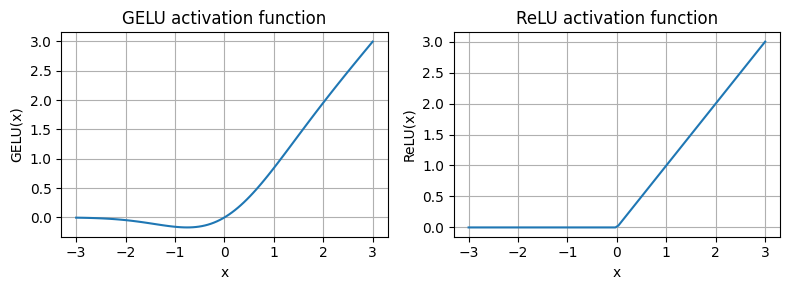

In [23]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
            (x + 0.044715 * torch.pow(x, 3))
        ))
import matplotlib.pyplot as plt

gelu, relu = GELU(), nn.ReLU()

# Some sample data
x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)

plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)

plt.tight_layout()
plt.show()

### Feed Forward Layer with GeLU

In [24]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)
    
ffn = FeedForward(GPT_CONFIG_124M)

# input shape: [batch_size, num_token, emb_size]
x = torch.rand(2, 10, 768) 
out = ffn(x)
print(out.shape)

torch.Size([2, 10, 768])


### Transformer-Decoder Block

In [31]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x) # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim) 
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)
        
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2) 
        
        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec

In [40]:

class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"], 
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg) # feed forward layer
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        # Shortcut connection for attention block
        shortcut = x    # store og x as shortcut
        x = self.norm1(x) # layer norm input x
        x = self.att(x)  # Shape [batch_size, num_tokens, emb_size] multihead attention layer
        x = self.drop_shortcut(x) # dropout
        #print(x.shape)
        x = x + shortcut  # Add the original input back, add residual

        # Shortcut connection for feed forward block
        shortcut = x #store temp shortcut value
        x = self.norm2(x) # layer norm x
        x = self.ff(x) #feedforward layer
        x = self.drop_shortcut(x) #dropout layer
        x = x + shortcut  # Add the original input back

        return x

In [41]:
torch.manual_seed(123)

x = torch.rand(2, 4, 768)  # Shape: [batch_size, num_tokens, emb_dim]
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)

print("Input shape:", x.shape)
print("Output shape:", output.shape)

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


In [42]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [43]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)

out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])
tensor([[[ 0.1381,  0.0077, -0.1963,  ..., -0.0222, -0.1060,  0.1717],
         [ 0.3865, -0.8408, -0.6564,  ..., -0.5163,  0.2369, -0.3357],
         [ 0.6989, -0.1829, -0.1631,  ...,  0.1472, -0.6504, -0.0056],
         [-0.4290,  0.1669, -0.1258,  ...,  1.1579,  0.5303, -0.5549]],

        [[ 0.1094, -0.2894, -0.1467,  ..., -0.0557,  0.2911, -0.2824],
         [ 0.0882, -0.3552, -0.3527,  ...,  1.2930,  0.0053,  0.1898],
         [ 0.6091,  0.4702, -0.4094,  ...,  0.7688,  0.3787, -0.1974],
         [-0.0612, -0.0737,  0.4751,  ...,  1.2463, -0.3834,  0.0609]]],
       grad_fn=<UnsafeViewBackward0>)


In [44]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 163,009,536


In [45]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (batch, n_tokens) array of indices in the current context
    for _ in range(max_new_tokens):
        
        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]
        
        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond)
        
        # Focus only on the last time step
        # (batch, n_tokens, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]  

        # Apply softmax to get probabilities
        probas = torch.softmax(logits, dim=-1)  # (batch, vocab_size)

        # Get the idx of the vocab entry with the highest probability value
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx

In [46]:
start_context = "Hello, I am"

encoded = tokenizer.encode(start_context)
print("encoded:", encoded)

encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encoded_tensor.shape:", encoded_tensor.shape)

encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


In [47]:
model.eval() # disable dropout

out = generate_text_simple(
    model=model,
    idx=encoded_tensor, 
    max_new_tokens=6, 
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output:", out)
print("Output length:", len(out[0]))

Output: tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348,  7267]])
Output length: 10


In [48]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

Hello, I am Featureiman Byeswickattribute argue
